In [1]:
%reset

Nothing done.


In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import copy
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch

from io import BytesIO
from time import sleep 
from tqdm import tqdm
from typing import List
from torch_geometric.data import Data

from config import (
    PATH_TO_FEATURES, 
    PATH_SUMMARY_DATASETS
)
from src.utils.global_vars import PlottingParameters

PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'

PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'

IMGS_PATH = 'imgs'
NOTEBOOKS_SUMMARY_FOLDER = 'v3'

sns.set_theme(style="white")

print("pytorch version:", torch.__version__)
print("is cuda available:", torch.cuda.is_available())

pytorch version: 1.13.0
is cuda available: False


In [3]:
os.system(f'mkdir ../../datasets/datasets_for_model_building/summary_datasets/{NOTEBOOKS_SUMMARY_FOLDER}')

mkdir: ../../datasets/datasets_for_model_building/summary_datasets/v3: File exists


256

# Build a Sparse Graph with as much landmark genes as possible

We already created two datasets with graphs per cell-line. 
- In [`07_v1_get_linking_dataset.ipynb`](07_v1_get_linking_dataset.ipynb) we created a dataset with gene-gene interactions graphs per cell-line of topology `Data(x=[858, 4], edge_index=[2, 83126])`. They have been saved in `../../datasets/datasets_for_model_building/cl_graphs_as_dict.pkl`.
  - __Problem__: The number of edges 83,126 was way to high to even run a single epoch locally.
- In [`07_v2_graph_dataset.ipynb`](07_v2_graph_dataset.ipynb) we created a dataset with gene-gene interactions graphs per cell-line of topology `Data(x=[458, 4], edge_index=[2, 4760])`. They have been saved in `../../datasets/datasets_for_model_building/cl_graphs_as_dict_SPARSE.pkl`. We selected first only the protein tuples with a combined score higher then 950 and then selected only the landmark genes.
  - __Problem__: Even though we lowered the number of edges significantly, now we lost nearly half of all the genes, which may provide valuable information.

_Objective_: The objective of this notebook is to lower the number of edges down from 83,126 __while maintaining as much genes as possible__.

_Approach_: We 1st select only landmark genes out of the protein database and then 2nd use the `combined_score` column in the protein-interaction dataset.

_TODOs_: 
- [ ] select only the protein-protein tuples where both proteins are landmark genes
- [ ] after the first step, tune the `combined_score` column threshold in such a way that as close to 858 genes as possible stay in the dataset

### Helper Methods

In [52]:
def read_protein_links(path: str):
    print(f"Start reading `{path}`...")
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_links_v1 = pd.read_csv(data, sep=' ')
    print("Finished reading.")

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_links_v2 = protein_links_v1.copy()
    protein_links_v2.protein1 = protein_links_v2.protein1.str[5:]
    protein_links_v2.protein2 = protein_links_v2.protein2.str[5:]

    return protein_links_v2

def read_protein_info(path: str):
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_info_v1 = pd.read_csv(data, sep='\t')
    protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, inplace=False)

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]

    return protein_info_v2

def combine_protein_links_with_info(links: pd.DataFrame, infos: pd.DataFrame):
    """
    Maps the corresponding gene symbols to the proteins in the protein link dataset.

    Args:
        links (pd.DataFrame): DataFrame containing at least the columns `protein1` and `protein2`.
        infos (pd.DataFrame): DataFrame containing at least the columns `string_protein_id` and `preferred_name`.
    Returns:
        (pd.DataFrame): DataFrame containing the corresponding `gene_symbol` per `protein1` and `protein2`.
    """
    # Get the gene symbols for the protein1 column.
    res = links.merge(right    = infos[['string_protein_id', 'preferred_name']],
                      how      = 'left',
                      left_on  = 'protein1',
                      right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Get the gene symbols for the protein2 column.
    res = res.merge(right    = infos[['string_protein_id', 'preferred_name']],
                    how      = 'left',
                    left_on  = 'protein2',
                    right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Drop all rows where the gene symbol has not been found.
    res.dropna(subset=['gene_symbol1', 'gene_symbol2'], inplace=True)

    assert not res[['gene_symbol1', 'gene_symbol2']].isna().sum().any(),\
        "Some gene_symbol columns are missing!"

    return res 

def add_gene_index(proteins: pd.DataFrame, gene_idxs: pd.DataFrame=GENE_SYMBOL_IDXS):
    """ 
    Append corresponding index for each gene symbol column as new column(s).
    """
    temp = proteins.merge(
        right=gene_idxs,
        how='left',
        left_on=['gene_symbol1'],
        right_on=['GENE_SYMBOL'])
    temp.rename(columns={'GENE_INDEX': 'index_gene_symbol1'}, inplace=True)
    temp.drop(['GENE_SYMBOL'], axis=1, inplace=True)

    res = temp.merge(
        right=gene_idxs,
        how='left',
        left_on=['gene_symbol2'],
        right_on=['GENE_SYMBOL'])
    res.rename(columns={'GENE_INDEX': 'index_gene_symbol2'}, inplace=True)
    res.drop(['GENE_SYMBOL'], axis=1, inplace=True) 

    del temp
    return res    

## Create protein dataset
In this section we will create the full base protein dataset which then will be used for further model-specific selection.
### Load protein link dataset
In this subsection we will load the protein linking dataset which contains for a given protein-protein tuple information about their certainty of connection.

> `combined_score` is calculated by combining multiple types of evidence for the interaction, such as experimental, text mining, co-expression, and co-localization

In [32]:
protein_links = read_protein_links(f'{PATH_TO_LINKING_DATA}{PROTEIN_LINKS_FILE}')
print(protein_links.shape)
protein_links.head(3)

Start reading `../../datasets/string/9606.protein.links.detailed.v11.5.txt.gz`...
Finished reading.
(11938498, 10)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


- there are 11,938,498 protein-protein connections in the given dataset
- each connection row contains a `combined_score` value

<AxesSubplot:>

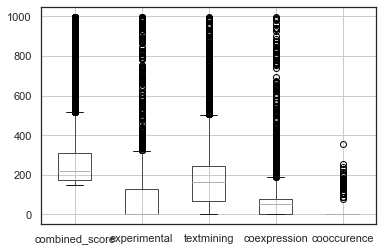

In [33]:
keep = [
    'combined_score',
    'experimental',
    'textmining',
    'coexpression',
    'cooccurence'
]
df = protein_links[keep].sample(10_000) #.boxplot(showfliers=False);
df.boxplot()

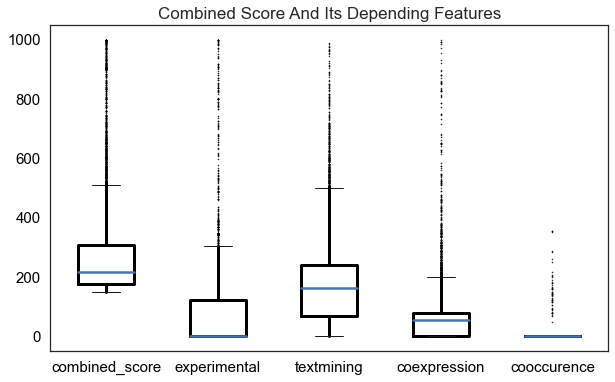

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

fac = 2

flierprops = dict(marker='.', markersize=1, linestyle='none', lw=10)

df.boxplot(flierprops=flierprops, 
    whiskerprops=dict(linestyle='-',linewidth=3, color='black'),
    medianprops=dict(linestyle='-', linewidth=2.5, color='C0'),
    boxprops= dict(linewidth=3.0, color='black'))

ax.tick_params(axis='x', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.tick_params(axis='y', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.set_ylabel(ylabel='', color='black', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
plt.grid(None) 
plt.title('Combined Score And Its Depending Features', fontsize=PlottingParameters.TITLE_FONTSIZE.value+fac);

plt.show()
fig.savefig(f'imgs/CombinedScoreAndItsDependingFeatures.eps', format='eps');


      coexpression textmining experimental combined_score
count     11938498   11938498     11938498       11938498
mean            62        180           69            280
std             97        153          120            167
min              0          0            0            150
25%              0         67            0            175
50%             54        161            0            216
75%             76        241          129            309
max            999        997          999            999


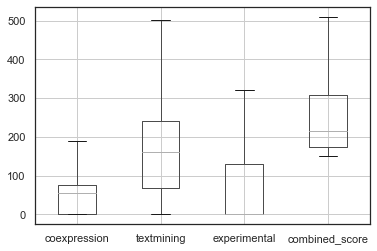

In [34]:
print(protein_links[['coexpression', 'textmining', 'experimental', 'combined_score']].describe().apply(lambda s: s.apply('{0:.0f}'.format)))
protein_links[['coexpression', 'textmining', 'experimental', 'combined_score']].boxplot(showfliers=False);

- the `combined_score` column seems to lie in $[150, 999]$

## Load protein info dataset

In this subsection we will load the protein information dataset which contains the gene symbol for each protein ID. This will be used to obtain the corresponding gene symbols for each protein `protein1` and `protein2` respectively in the protein link dataset from the previous subsection.

In [35]:
protein_infos_v0 = read_protein_info(f'{PATH_TO_LINKING_DATA}{PROTEIN_INFO_FILE}')
print(protein_infos_v0.shape)
print(f"There are {len(protein_infos_v0.preferred_name.unique())} unique gene symbols in `preferred_name`.")
protein_infos_v0.head(3)

(19566, 4)
There are 19563 unique gene symbols in `preferred_name`.


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


- this dataset gives us the gene symbol for each protein ID.
- some `preferred_name` (gene symbols) occur more then one time

In [36]:
freq_per_gene = protein_infos_v0.groupby(['preferred_name']).size().reset_index(name='freq', inplace=False).sort_values(['freq'], ascending=False)
print(freq_per_gene[freq_per_gene.freq>1])

# Remove the gene symbols which have a frequency higher than 1.
protein_infos = protein_infos_v0[~protein_infos_v0.preferred_name.isin(freq_per_gene[freq_per_gene.freq>1].preferred_name.tolist())]
print(protein_infos.shape)
protein_infos.head(3)

       preferred_name  freq
5100  ENSG00000205457     2
5106  ENSG00000229117     2
5243  ENSG00000268221     2
(19560, 4)


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


### Combine protein link and info

In this subsection we will add the `preferred_name`'s to the protein columns of the link dataset. This way we obtain the corresponding gene symbols for each protein of each tuple.

In [37]:
proteins = combine_protein_links_with_info(protein_links, protein_infos)
print(proteins.shape)
proteins.head(3)

(11936122, 12)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36


In [38]:
print(f"""Shapes
    before joining : {protein_links.shape}
    after  joining : {proteins.shape}
There are 
    {len(proteins.gene_symbol1.unique())} unique genes (gene_symbol1) per column
    {len(proteins.gene_symbol2.unique())} unique genes (gene_symbol2) per column    
""")
# Unique number of gene-gene combinations.
freq_per_tuple = proteins\
    .groupby(['gene_symbol1', 'gene_symbol2']).size()\
    .reset_index(name='freq', inplace=False)\
    .sort_values(['freq'], ascending=False)
freq_per_tuple.groupby(['freq']).size().reset_index(name='count', inplace=False)

Shapes
    before joining : (11938498, 10)
    after  joining : (11936122, 12)
There are 
    19379 unique genes (gene_symbol1) per column
    19379 unique genes (gene_symbol2) per column    



,freq,count
0,1,11936122


## Select only landmark genes

In this subsection we will select only the gene-gene tuples `(gene_i, gene_j)` where both `gene_i` and `gene_j` are landmark genes.

In [39]:
with open(f'{PATH_TO_FEATURES}intersecting_genes.pkl', 'rb') as f: 
    LANDMARK_GENES = list(pd.read_pickle(f))
print("Number of landmark genes:", len(LANDMARK_GENES))
# Assign unique index to each of the genes.
LM_GENES_IDXS = pd.DataFrame({'GENE_SYMBOL': list(LANDMARK_GENES)})
LM_GENES_IDXS['GENE_INDEX'] = LM_GENES_IDXS.index
LM_GENES_IDXS.head(5)

Number of landmark genes: 858


,GENE_SYMBOL,GENE_INDEX
0,ARNT2,0
1,FIS1,1
2,ICAM1,2
3,TRIM2,3
4,IPO13,4


In [40]:
# How many of the intersecting genes are also in the protein-protein interaction dataset?
print(len(list(set(proteins.gene_symbol1.unique()).intersection(set(LM_GENES_IDXS.GENE_SYMBOL.unique())))))
print(len(list(set(proteins.gene_symbol2.unique()).intersection(set(LM_GENES_IDXS.GENE_SYMBOL.unique())))))

858
858


In [41]:
# Select only the rows where both gene symbols are landmark genes
proteins_lm = proteins[(proteins.gene_symbol1.isin(LM_GENES_IDXS.GENE_SYMBOL)) &
                       (proteins.gene_symbol2.isin(LM_GENES_IDXS.GENE_SYMBOL))]
print(f"{proteins_lm.shape}, thus {100-100*proteins_lm.shape[0]/proteins.shape[0]:2.2f} % got removed")
uniq_g1, uniq_g2 = len(proteins_lm.gene_symbol1.unique()), len(proteins_lm.gene_symbol2.unique())
print(f"Number of unique gene_symbol1's: {uniq_g1} ({100-100*uniq_g1/len(proteins.gene_symbol1.unique()):2.2f} % got removed)")
print(f"Number of unique gene_symbol2's: {uniq_g2} ({100-100*uniq_g2/len(proteins.gene_symbol2.unique()):2.2f} % got removed)")
proteins_lm.head(3)

(83126, 12), thus 99.30 % got removed
Number of unique gene_symbol1's: 858 (95.57 % got removed)
Number of unique gene_symbol2's: 858 (95.57 % got removed)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
1940,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5
1953,ENSP00000001008,ENSP00000306245,0,0,0,0,59,0,177,192,FKBP4,FOS
1978,ENSP00000001008,ENSP00000340989,0,0,0,0,78,0,123,157,FKBP4,SFN


## Tune `combined_score` threshold

In this subsection we are going to tune the `combined_score` column such that as many gene symbols as possible stay in the resulting dataset.

In [44]:
threshs = np.arange(0.1, 1.0, 0.05)
rows = np.repeat(None, len(threshs))
uniq_g1s, uniq_g2s = np.repeat(None, len(threshs)), np.repeat(None, len(threshs))
for i, thresh in enumerate(threshs): 
    # print(f"thresh: {thresh*1_000:3.0f}\n{20*'='}")
    protein_temp = proteins_lm[proteins_lm['combined_score'] > (thresh * 1_000)]
    rows[i] = protein_temp.shape[0]
    uniq_g1s[i] = len(protein_temp.gene_symbol1.unique())
    uniq_g2s[i] = len(protein_temp.gene_symbol2.unique())

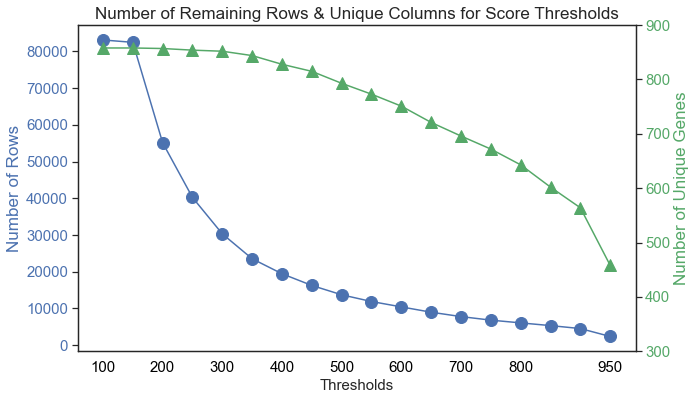

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 6))

fac = 2
markersize = 12

ax1.plot(threshs*1_000, rows, 'bo-', markersize=markersize);
ax1.set_xlabel("Thresholds", fontsize=15);
ax1.set_ylabel("Number of Rows", color='b', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
ax1.tick_params(axis='y', labelcolor = 'b', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac)

ax2 = ax1.twinx()
ax2.plot(threshs*1_000, uniq_g1s, 'g^-', markersize=markersize);
# ax2.axhline(y=700, color='grey', linestyle='--');
ax2.set_ylabel("Number of Unique Genes", color='g', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
ax2.tick_params(axis='y', labelcolor = 'g', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax2.set_ylim(300, 900);

# for thresh in threshs:
#     ax1.axvline(x=thresh*1_000, color='grey', linestyle='-', alpha=0.2);

plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 950]);
ax1.tick_params(axis='x', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
plt.title("Number of Remaining Rows & Unique Columns for Score Thresholds", 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+fac);
plt.show();
fig.savefig(f'imgs/NumberOfRemainingRowsAndUniqueColumnsForScoreThresholds.eps', format='eps');


[Zhu et. al., 2022](https://academic.oup.com/bioinformatics/article/38/2/461/6374919) also only worked with GDSC2 and ended up with 706 genes. Thus, an orientation number for the unique number of genes we want to have after choosing a threshold could be 700.

In [54]:
# -------------------------------------- #
# Read cell-line - gene feature datasets #
# -------------------------------------- #
READ = True

if READ:
    start = time.time()
    with open(f'{PATH_TO_FEATURES}gexpr_sparse.pkl', 'rb') as f: 
        gexpr = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvg_sparse.pkl', 'rb') as f: 
        cnvg = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvp_sparse.pkl', 'rb') as f: 
        cnvp = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}mut_sparse.pkl', 'rb') as f: 
        mut = pickle.load(f)  
    print(f"Took {time.time()-start:.5f} seconds to read the cell-line feature datasets.")
    print(f"""Shapes
    Gene Expression : {gexpr.shape}
    CNV Gistic      : {cnvg.shape}
    CNV Picnic      : {cnvp.shape}
    Mutation        : {mut.shape}
    """)

    gexpr.set_index('CELL_LINE_NAME', inplace=True)
    cnvg.set_index('CELL_LINE_NAME', inplace=True)
    cnvp.set_index('CELL_LINE_NAME', inplace=True)
    mut.set_index('CELL_LINE_NAME', inplace=True)    

from typing import Tuple, FrozenSet

def create_cell_line_gene_graphs(gene_symbols: List[str], 
                                 gene_features: List[pd.DataFrame], 
                                 cls: List[str],
                                 neighbor_gene_tuples: List[Tuple[int]]):
    """ 
    Creates pytorch geometric gene-gene interaction graphs for each of the
    given cell-lines. The each graph has the exact same topology, meaning
    the same gene symbols as nodes and the same edges. However, each graph
    has different gene feature values per node.

    Args: 
        gene_symbols (`List[str]`):
            List of gene symbols which need to be available as columns in the 
            gene features (`gene_features`).
        gene_features (`List[pd.DataFrame]`):
            List of feature pd.DataFrame's. All dataframe need to have all the 
            given cell-lines (`cls`) as indices and gene symbols (`gene_symbols`) as 
            columns.
        cls (`List[str]`):
            List of cell-lines for which to create graphs.
        neighbor_gene_tuples (`List[Tuple[int]]`):
            List of tuples of neighbors, where the neighbors are given as gene indices, 
            not symbols.
    Returns:
        `Dict[torch_geometric.data.Data]`:
            Dictionary with the cell-line names as keys and pytorch geometric
            gene-gene interaction graphs as values.
    """
    Gs = {}
    for cl in tqdm(cls):
        # Convert the feature values to tensors and stack them up.
        cl_features = []
        for feature in gene_features:
            cl_features.append(torch.tensor(feature.loc[cl][gene_symbols].values, dtype=torch.float64))
        features = torch.stack(cl_features).t()

        # Generate the graph.
        edge_index = torch.tensor(neighbor_gene_tuples, dtype=torch.long).t().contiguous()
        G_cl = Data(x=features, edge_index=edge_index)

        Gs[cl] = G_cl

    return Gs    

Took 0.02817 seconds to read the cell-line feature datasets.
Shapes
    Gene Expression : (983, 859)
    CNV Gistic      : (983, 859)
    CNV Picnic      : (983, 859)
    Mutation        : (983, 859)
    


In [215]:
from torch_geometric.utils import degree

lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED = {}
lst_GENE_SYMBOL_IDXS= {}

for thresh in [600, 700, 800, 900, 950, 990]:
    print(f"{thresh:=^20}")
    SCORE_THRESH = thresh

    gexpr.reset_index(inplace=True)
    cnvg.reset_index(inplace=True)
    cnvp.reset_index(inplace=True)
    mut.reset_index(inplace=True)    

    # Select only the rows above the chose threshold.
    proteins_above = proteins_lm[proteins_lm['combined_score'] > SCORE_THRESH]
    print(f"Choosing threshold {SCORE_THRESH} we end up with shape: {proteins_above.shape}")
    print("Number of unique gene_symbol1's:", len(proteins_above.gene_symbol1.unique()))
    print("Number of unique gene_symbol2's:", len(proteins_above.gene_symbol2.unique()))
    assert set(proteins_above.gene_symbol1.unique()) == set(proteins_above.gene_symbol2.unique()), \
        "ERROR: The unique gene_symbol1's are not the same as the unique gene_symbol2's!"
    UNIQ_GENE_SYMBOLS = list(set(proteins_above.gene_symbol1.unique()))

    # Select only the gene symbols with a combined_score > SCORE_THRESH.
    temp = LM_GENES_IDXS[LM_GENES_IDXS.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]
    temp.reset_index(inplace=True, drop=True)
    GENE_SYMBOL_IDXS = temp.copy()
    GENE_SYMBOL_IDXS.loc[:, 'GENE_INDEX'] = GENE_SYMBOL_IDXS.index
    del temp
    print("Shape before:", LM_GENES_IDXS.shape)
    print(LM_GENES_IDXS.head(3))
    print("Shape after :", GENE_SYMBOL_IDXS.shape)
    print(GENE_SYMBOL_IDXS.head(3))

    GENE_SYMBOL_IDXS.to_csv(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/gene_symbol_idx_map_{SCORE_THRESH}.csv')

    # Remember the gene symbol index mapping.
    lst_GENE_SYMBOL_IDXS[SCORE_THRESH] = GENE_SYMBOL_IDXS

    proteins_above_with_idx = add_gene_index(proteins_above, GENE_SYMBOL_IDXS)
    proteins_above_with_idx = proteins_above_with_idx[['protein1', 'protein2', 
                                                    'gene_symbol1', 'gene_symbol2', 
                                                    'index_gene_symbol1', 'index_gene_symbol2', 
                                                    'combined_score']]

    NODES_AS_SYMBOLS = np.unique(proteins_above_with_idx[['gene_symbol1', 'gene_symbol2']].values)
    NODES_AS_INDECES = np.unique(proteins_above_with_idx[['index_gene_symbol1', 'index_gene_symbol2']].values)
    print(f"There will be {len(NODES_AS_SYMBOLS)} nodes in the graph.")
    print(f"There will be {len(NODES_AS_INDECES)} indices in the graph.")

    print(proteins_above_with_idx.shape)
    proteins_above_with_idx.head(3)

    # Create a list of tuples which hold neighbor nodes.
    gene_symbol_tuples = list(set(list(zip(proteins_above_with_idx.gene_symbol1, 
                                        proteins_above_with_idx.gene_symbol2))))
    print(gene_symbol_tuples[:5])

    # Map the list of tuples of neighbor gene nodes to the corresponding int. 
    transform_gene_tuple_to_index_tuple = lambda x : (
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
    input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]
    print(input_vec[:5])

    neighbor_gene_tuples = copy.deepcopy(input_vec)
    print("Number of neighbor tuples:", len(neighbor_gene_tuples))

    def is_undirected_list_of_tuples(neighbors: List[tuple[int]]):
        for neigh in neighbors:
            a, b = neigh[0], neigh[1]
            found = False
            for n in neighbors:
                if n == (b, a):
                    found = True
                    break
            assert found, f"ERROR: the list if directed since, couldn't find ({b}, {a}) for {neigh}!"
        print("SUCCESS: The given list of tuples is undirected!")

    print(is_undirected_list_of_tuples(neighbor_gene_tuples))

    NEIGHBOR_GENE_TUPLES_UNDIRECTED = neighbor_gene_tuples
    print(len(NEIGHBOR_GENE_TUPLES_UNDIRECTED))
    
    # Remember the neighbor tuples.
    lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED[SCORE_THRESH] = NEIGHBOR_GENE_TUPLES_UNDIRECTED

    # Find neighbors using the indices.
    dict_as_indices = {gene_node: [] for gene_node in NODES_AS_INDECES}  # or dict(zip(nodes, []*len(nodes)))

    # Get the edges.
    for gene in dict_as_indices:
        exists_in_gene_symbol1 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].empty
        exists_in_gene_symbol2 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].empty

        neighbor_nodes = None 
        if exists_in_gene_symbol1:
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].index_gene_symbol2))
        elif exists_in_gene_symbol2: 
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].index_gene_symbol1))
        else: 
            print(f"The gene {gene} couldn't be found in the dataset!") 

        # Set neighbors for the gene.
        dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

    def get_uniqs(df: pd.DataFrame, col: str):
        return np.unique(df[col].values).tolist()

    # Test that all feature datasets contains exactly the same cell-lines.
    gexpr_cls = get_uniqs(gexpr, 'CELL_LINE_NAME')
    cnvg_cls = get_uniqs(cnvg, 'CELL_LINE_NAME')
    cnvp_cls = get_uniqs(cnvp, 'CELL_LINE_NAME')
    mut_cls = get_uniqs(mut, 'CELL_LINE_NAME')
    INTER_CLS = set(gexpr_cls) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(mut_cls))

    assert len(INTER_CLS) == len(gexpr_cls) == len(cnvg_cls) == len(cnvp_cls) == len(mut_cls), \
        "Not all feature datasets contain the exact same cell-lines as rows!"

    # Test that all feature datasets contains exactly the same gene symbols.
    inter_genes = set(np.unique(gexpr.columns.values).tolist()) \
        .intersection(set(np.unique(cnvg.columns.values).tolist())) \
        .intersection(set(np.unique(cnvp.columns.values).tolist())) \
        .intersection(set(np.unique(mut.columns.values).tolist()))

    assert len(inter_genes) == \
        len(np.unique(gexpr.columns.values).tolist()) == \
        len(np.unique(cnvg.columns.values).tolist()) == \
        len(np.unique(cnvp.columns.values).tolist()) == \
        len(np.unique(mut.columns.values).tolist()), \
            "Not all feature datasets contain the exact same gene symbols as columns!"

    del gexpr_cls, cnvg_cls, cnvp_cls, mut_cls, inter_genes
    
    gexpr.set_index('CELL_LINE_NAME', inplace=True)
    cnvg.set_index('CELL_LINE_NAME', inplace=True)
    cnvp.set_index('CELL_LINE_NAME', inplace=True)
    mut.set_index('CELL_LINE_NAME', inplace=True)

    cl_graphs = create_cell_line_gene_graphs(NODES_AS_SYMBOLS.tolist(), 
                                            [gexpr, cnvg, cnvp, mut],
                                            list(INTER_CLS),
                                            NEIGHBOR_GENE_TUPLES_UNDIRECTED)

    # Showcase topology for some cell-line examples.
    for cl in gexpr.index[:5].tolist():
        print(f"Cell-line: {cl:8s}   Graph: {cl_graphs[cl]}")

    with open(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/cl_graphs_dict_{SCORE_THRESH}.pkl', 'wb') as f:
        pickle.dump(cl_graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

========600=========
Choosing threshold 600 we end up with shape: (10436, 12)
Number of unique gene_symbol1's: 751
Number of unique gene_symbol2's: 751
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (751, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2       IPO13           2
There will be 751 nodes in the graph.
There will be 751 indices in the graph.
(10436, 7)
[('ERBB2', 'PDGFA'), ('ATP6V0B', 'SESN1'), ('TRIM13', 'SQSTM1'), ('SQSTM1', 'SPRED2'), ('PYCR1', 'LAP3')]
[(102, 486), (342, 624), (348, 221), (221, 84), (691, 5)]
Number of neighbor tuples: 10436
SUCCESS: The given list of tuples is undirected!
None
10436


100%|██████████| 983/983 [00:08<00:00, 113.37it/s]


Cell-line: 22RV1      Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 23132-87   Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 42-MG-BA   Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 451Lu      Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 5637       Graph: Data(x=[751, 4], edge_index=[2, 10436])
========700=========
Choosing threshold 700 we end up with shape: (7794, 12)
Number of unique gene_symbol1's: 696
Number of unique gene_symbol2's: 696
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (696, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2        FZD1           2
There will be 696 nodes in the graph.
There will be 696 indices in the graph.
(7794, 7)
[('ERBB2', 'PDGFA'), ('ATP6V0B', 'SESN1'), ('TRIM13', 'SQSTM1'), ('SQSTM1', 'SPRED2'), ('PYCR1', 'LAP3')]
[(95, 455), (318, 583), (324, 207), (207, 79), (645, 4)]

100%|██████████| 983/983 [00:07<00:00, 124.83it/s]


Cell-line: 22RV1      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 23132-87   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 42-MG-BA   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 451Lu      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 5637       Graph: Data(x=[696, 4], edge_index=[2, 7794])
========800=========
Choosing threshold 800 we end up with shape: (6080, 12)
Number of unique gene_symbol1's: 643
Number of unique gene_symbol2's: 643
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (643, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2        FZD1           2
There will be 643 nodes in the graph.
There will be 643 indices in the graph.
(6080, 7)
[('ATP6V0B', 'SESN1'), ('TRIM13', 'SQSTM1'), ('PYCR1', 'LAP3'), ('AURKA', 'KIF14'), ('HSPA1A', 'NUP88')]
[(292, 538), (298, 191), (598, 4), (557, 600), (247, 163)]
Num

100%|██████████| 983/983 [00:06<00:00, 143.67it/s]


Cell-line: 22RV1      Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 23132-87   Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 42-MG-BA   Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 451Lu      Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 5637       Graph: Data(x=[643, 4], edge_index=[2, 6080])
========900=========
Choosing threshold 900 we end up with shape: (4536, 12)
Number of unique gene_symbol1's: 564
Number of unique gene_symbol2's: 564
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (564, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2        FZD1           2
There will be 564 nodes in the graph.
There will be 564 indices in the graph.
(4536, 7)
[('HSPA4', 'HSPA8'), ('AXIN1', 'TGFBR2'), ('PPP2R5A', 'FZD1'), ('ATP6V0B', 'SESN1'), ('TOP2A', 'CCNB1')]
[(208, 118), (515, 489), (210, 2), (257, 469), (163, 98)]
Numb

100%|██████████| 983/983 [00:05<00:00, 172.89it/s]


Cell-line: 22RV1      Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 23132-87   Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 42-MG-BA   Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 451Lu      Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 5637       Graph: Data(x=[564, 4], edge_index=[2, 4536])
========950=========
Choosing threshold 950 we end up with shape: (2380, 12)
Number of unique gene_symbol1's: 458
Number of unique gene_symbol2's: 458
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (458, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2       RRP1B           2
There will be 458 nodes in the graph.
There will be 458 indices in the graph.
(2380, 7)
[('HSPA4', 'HSPA8'), ('TOP2A', 'CCNB1'), ('HSPA1A', 'BAG3'), ('STAT5B', 'PTPN1'), ('MAPK9', 'TP53')]
[(174, 99), (139, 81), (183, 361), (16, 338), (442, 90)]
Number of

100%|██████████| 983/983 [00:05<00:00, 188.76it/s]


Cell-line: 22RV1      Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 23132-87   Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 42-MG-BA   Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 451Lu      Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 5637       Graph: Data(x=[458, 4], edge_index=[2, 2380])
========990=========
Choosing threshold 990 we end up with shape: (874, 12)
Number of unique gene_symbol1's: 293
Number of unique gene_symbol2's: 293
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0       ARNT2           0
1        FIS1           1
2       ICAM1           2
Shape after : (293, 2)
  GENE_SYMBOL  GENE_INDEX
0        FIS1           0
1       ICAM1           1
2       CFLAR           2
There will be 293 nodes in the graph.
There will be 293 indices in the graph.
(874, 7)
[('CDK2', 'CCND3'), ('SHC1', 'SRC'), ('CFLAR', 'FAS'), ('CHMP6', 'VPS28'), ('DNMT1', 'RB1')]
[(31, 141), (60, 165), (2, 163), (234, 19), (215, 66)]
Number of neighbor tu

100%|██████████| 983/983 [00:03<00:00, 249.40it/s]


Cell-line: 22RV1      Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 23132-87   Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 42-MG-BA   Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 451Lu      Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 5637       Graph: Data(x=[293, 4], edge_index=[2, 874])


In [59]:
diff_cl_graphs = {}
for thresh in [600, 700, 800, 900, 950, 990]:
    with open(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/cl_graphs_dict_{thresh}.pkl', 'rb') as f:
        cl_graphs = pd.read_pickle(f)
        diff_cl_graphs[thresh] = cl_graphs

In [329]:
from torch_geometric.utils import degree

# Number of neighbors per graph.
g = cl_graphs['22RV1']
print(g)
print(g.edge_index[0])
print(g.edge_index)
print(g.num_nodes)
deg = degree(g.edge_index[0], g.num_nodes)
print(deg[0])
g.edge_index.shape

Data(x=[696, 4], edge_index=[2, 7794])
tensor([233, 652, 268,  ...,  85, 127, 690])
tensor([[233, 652, 268,  ...,  85, 127, 690],
        [431, 238, 510,  ..., 276, 441, 226]])
696
tensor(16.)


torch.Size([2, 7794])

# Final dataset summary

In this section we will some EDA on the final dataset.

In [18]:
from torch_geometric.utils import degree

def print_graph_information(data): 
    print(f"""
        General graph information:
        ==========================
        topology           : {data}
        num_nodes          : {data.num_nodes}
        num_edges          : {data.num_edges}
        num_node_features  : {data.num_node_features}
        num_edge_features  : {data.num_edge_features}
        has_isolated_nodes : {data.has_isolated_nodes()}
        has_self_loops     : {data.has_self_loops()}
        is_directed        : {data.is_directed()}
        is_undirected      : {data.is_undirected()}    
    """)

In [25]:
ls -lh ../../datasets/datasets_for_model_building/summary_datasets/GraphTab/v3/

total 296376
-rw-r--r--@ 1 cwoest  staff   141K Nov 23 20:30 GraphPlotForGene_E2F2.svg
-rw-r--r--  1 cwoest  staff    49K Nov 23 20:31 NumberOfNeighborsPerCellLineGraphWithMeanMedian.svg
-rw-r--r--  1 cwoest  staff    48K Nov 23 20:32 NumberOfRemainingRowsAndUniqueColumnsForScoreThresholds.svg
-rw-r--r--  1 cwoest  staff   138M Nov 23 18:20 cl_graphs_dict.pkl
-rw-r--r--@ 1 cwoest  staff   3.3M Nov  3 17:02 drug_response_matrix__gdsc2.pkl
-rw-r--r--@ 1 cwoest  staff   308K Nov  1 11:50 drug_smiles_fingerprints_matrix.pkl
-rw-r--r--@ 1 cwoest  staff   9.3K Nov 23 22:19 gene_symbol_idx_map.csv
-rw-r--r--  1 cwoest  staff   2.4M Nov 24 03:19 model_performance


In [26]:
with open('../../datasets/datasets_for_model_building/summary_datasets/GraphTab/v3/cl_graphs_dict.pkl', 'rb') as f:
    cl_graphs = pd.read_pickle(f)

print(f"There are {len(cl_graphs.keys())} cell-line graphs in the dataset.")
exCl = '22RV1'
# Example graph for analysis purposes.
exG = cl_graphs[exCl]
print("Each graph has topology:", exG)
print_graph_information(exG)

There are 983 cell-line graphs in the dataset.
Each graph has topology: Data(x=[696, 4], edge_index=[2, 7794])

        General graph information:
        topology           : Data(x=[696, 4], edge_index=[2, 7794])
        num_nodes          : 696
        num_edges          : 7794
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : False
        has_self_loops     : False
        is_directed        : False
        is_undirected      : True    
    


Todos: 

- [ ] show number of neighbors boxplots for different `combined_score_thresholds`

In [121]:
node_degrees_lsts = []
mus = []
sds = []
for thresh, cl_graphs in diff_cl_graphs.items():
    exCl = '22RV1'
    exG = cl_graphs[exCl]

    node_degrees = degree(exG.edge_index[0], exG.num_nodes)
    node_degrees_lst = [d.item() for d in node_degrees]
    mu, med = torch.mean(node_degrees).item(), torch.median(node_degrees).item() 
    sd = np.std(node_degrees_lst)
    print(f"{thresh:20} {mu:2.5f} +- {sd:2.2f}   {med}   max: {max(node_degrees_lst)}")
    mus.append(mu)
    sds.append(sd)

    node_degrees_lsts.append(node_degrees_lst)


                 600 13.89614 +- 18.33   7.0   max: 179.0
                 700 11.19828 +- 14.72   5.0   max: 139.0
                 800 9.45568 +- 12.50   5.0   max: 121.0
                 900 8.04255 +- 10.60   4.0   max: 96.0
                 950 5.19651 +- 7.02   2.0   max: 63.0
                 990 2.98294 +- 3.26   2.0   max: 29.0


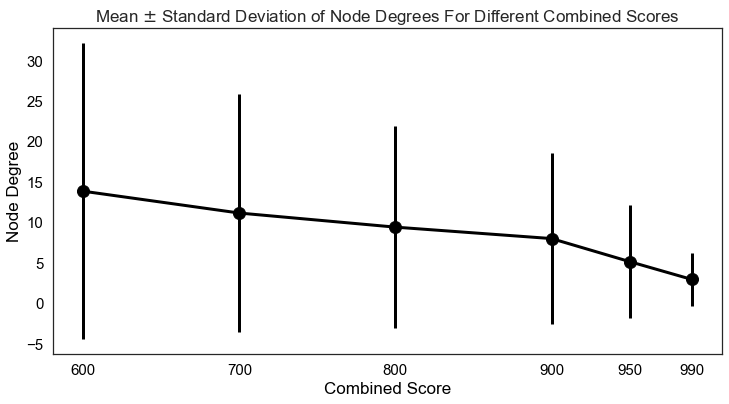

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(
    [600, 700, 800, 900, 950, 990], 
    mus, 
    yerr=sds,
    fmt='-o', 
    lw=3,
    markersize=12,
    color='black'
)
ax.tick_params(axis='x', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.tick_params(axis='y', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.set_xlabel(xlabel='Combined Score', color='black', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
ax.set_ylabel(ylabel='Node Degree', color='black', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);

ax.set_xticks([600, 700, 800, 900, 950, 990])
ax.set_xticklabels([600, 700, 800, 900, 950, 990]);

ax.set_title(f'Mean $\pm$ Standard Deviation of Node Degrees For Different Combined Scores', fontsize=PlottingParameters.TITLE_FONTSIZE.value+fac);

plt.show()

SAVE = True
if SAVE:
    fig.savefig(f'imgs/NodeDegreesWithErrorBars.eps', format='eps');

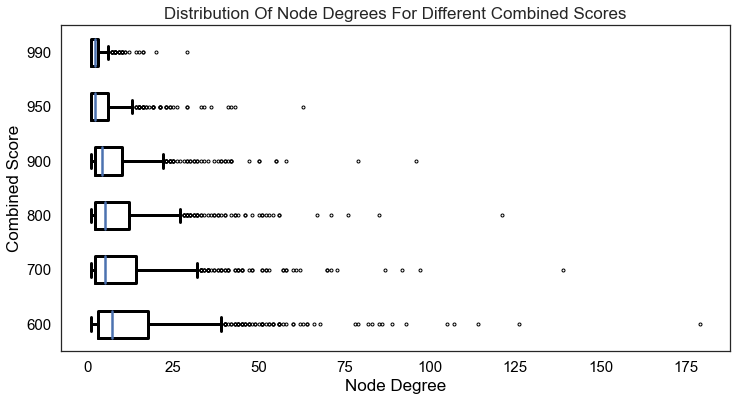

In [108]:
fig, ax = plt.subplots(figsize=(12, 6))

fac = 2

ax.boxplot(node_degrees_lsts, positions=range(len(node_degrees_lsts)),
    flierprops=dict(marker='o', markersize=3, linestyle='none', lw=10), 
    whiskerprops=dict(linestyle='-',linewidth=3, color='black'),
    medianprops=dict(linestyle='-', linewidth=2.5, color='C0'),
    boxprops= dict(linewidth=3.0, color='black'), 
    capprops=dict(linestyle='-', linewidth=3, color='black'),
    showfliers=True,
    vert=False)

ax.tick_params(axis='x', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.tick_params(axis='y', labelcolor='black', labelsize=PlottingParameters.YTICKS_LABELSIZE.value+fac);
ax.set_ylabel(ylabel='Combined Score', color='black', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
ax.set_xlabel(xlabel='Node Degree', color='black', fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);

ax.set_yticklabels([600, 700, 800, 900, 950, 990]);

ax.grid(None) 
plt.grid(None)
ax.set_title('Distribution Of Node Degrees For Different Combined Scores', fontsize=PlottingParameters.TITLE_FONTSIZE.value+fac);

plt.show()    

SAVE = True
if SAVE:
    fig.savefig(f'imgs/DistOfNodeDegreesForDifferentCombinedScores.eps', format='eps');

In [ ]:
NEIGHBOR_GENE_TUPLES_UNDIRECTED
GENE_SYMBOL_IDXS

In [213]:
len(all_neighbors)

17

In [214]:
all_neighbors

[59,
 66,
 131,
 202,
 303,
 332,
 346,
 355,
 399,
 517,
 523,
 525,
 531,
 561,
 640,
 665,
 685]

In [210]:
neighbor_nodes

['TP53BP1', 'RB1', 'SKIV2L', 'ORC1']

In [212]:
middle_node

'CDK7'


        General graph information:
        topology           : Data(x=[52, 4], edge_index=[2, 430])
        num_nodes          : 52
        num_edges          : 430
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : True
        is_undirected      : False    
    


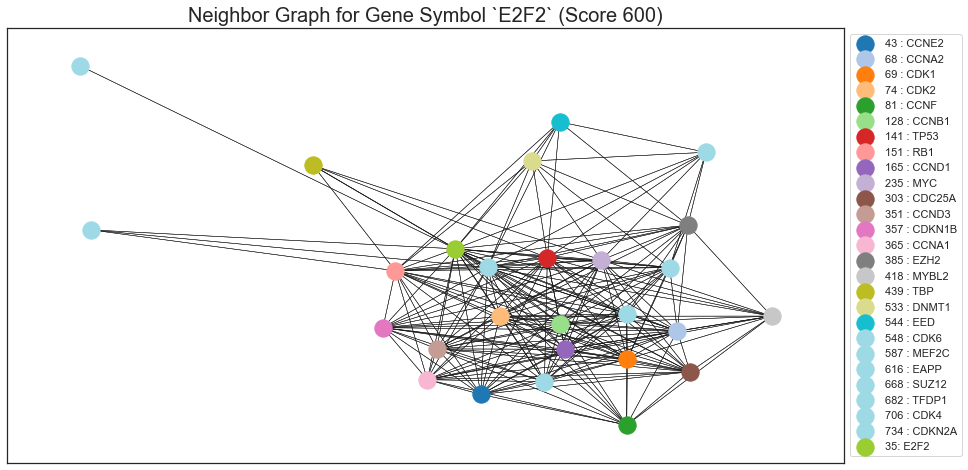

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [263]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 600

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=0.5, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5));
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[38, 4], edge_index=[2, 208])
        num_nodes          : 38
        num_edges          : 208
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : True
        is_undirected      : False    
    


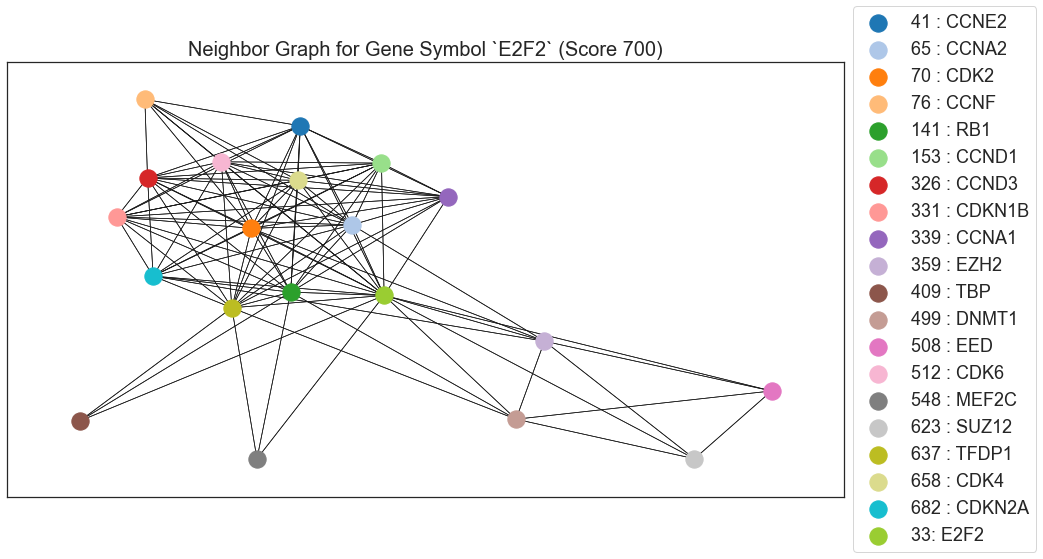

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [258]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 700

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=0.7, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[36, 4], edge_index=[2, 180])
        num_nodes          : 36
        num_edges          : 180
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : False
        is_undirected      : True    
    


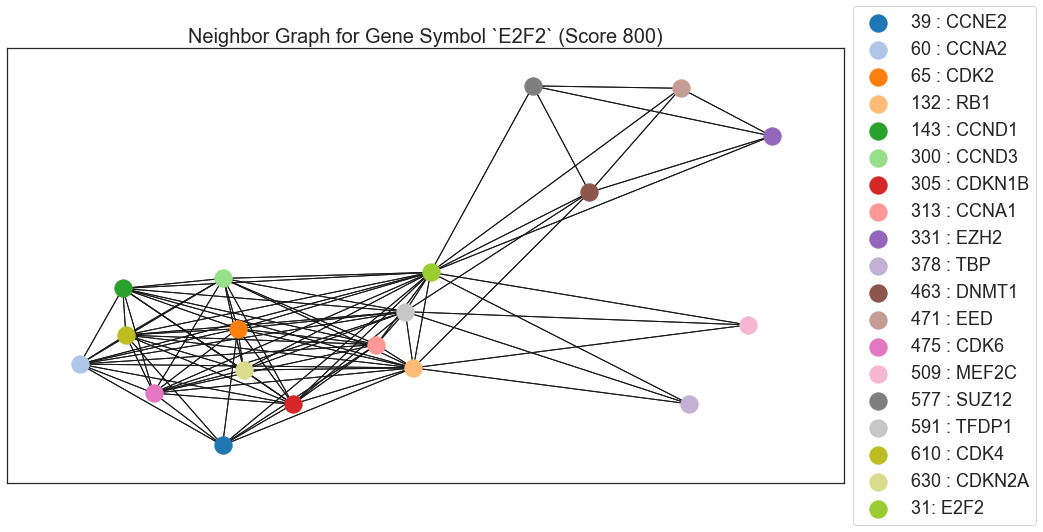

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [257]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 800

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=1, arrows=False);
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[36, 4], edge_index=[2, 174])
        num_nodes          : 36
        num_edges          : 174
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : True
        is_undirected      : False    
    


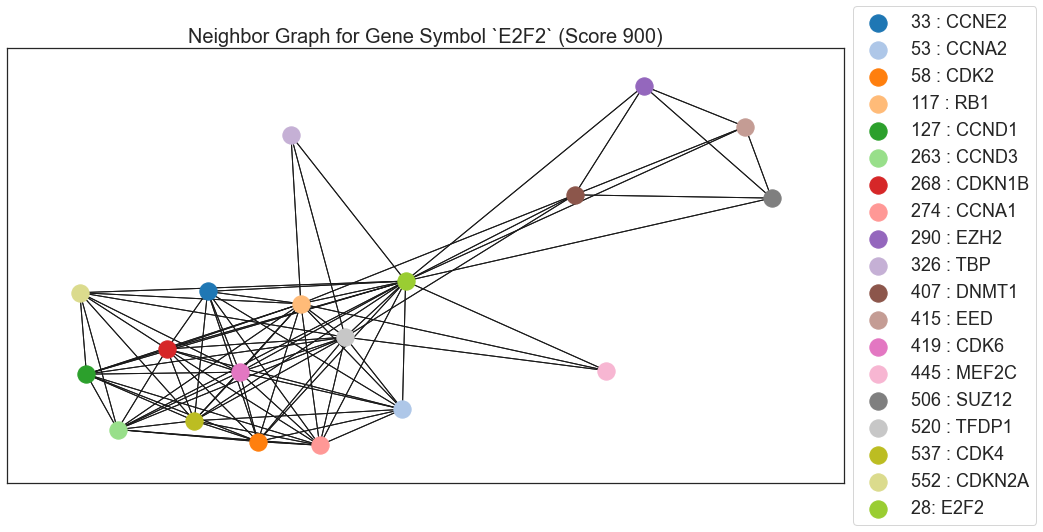

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [256]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 900

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=1, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[22, 4], edge_index=[2, 94])
        num_nodes          : 22
        num_edges          : 94
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : False
        is_undirected      : True    
    


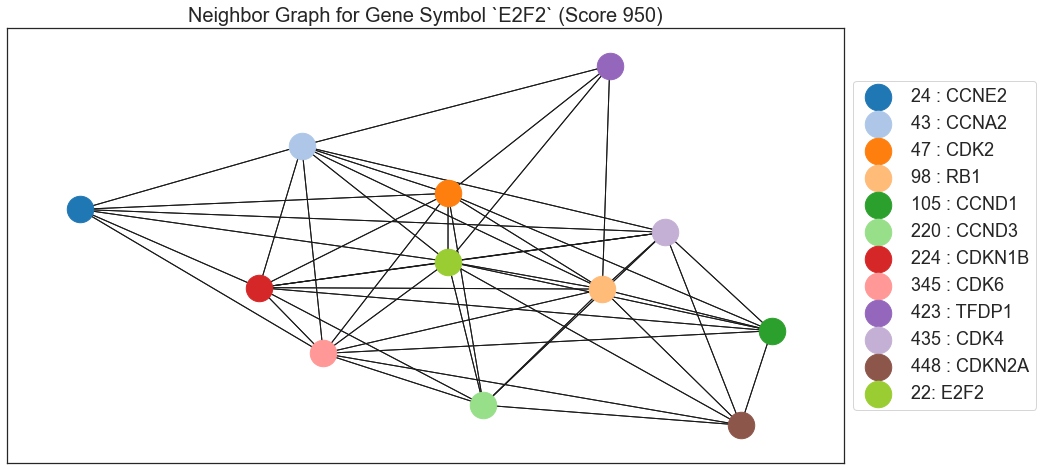

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [255]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 950

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=700,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=700,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=1, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[4, 4], edge_index=[2, 6])
        num_nodes          : 4
        num_edges          : 6
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : False
        is_undirected      : True    
    


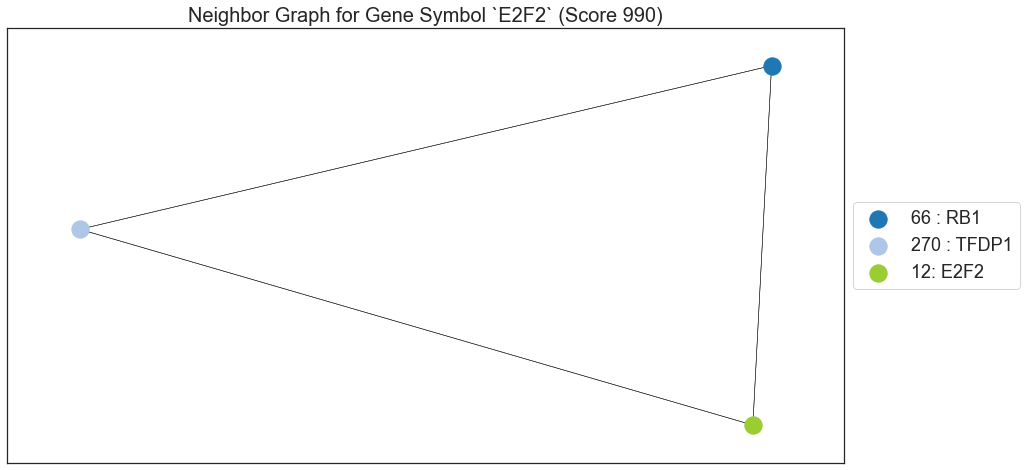

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [254]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 990

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=0.5, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Score {thresh})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value+5);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_{thresh}.eps', format='eps', bbox_inches='tight');


        General graph information:
        topology           : Data(x=[36, 4], edge_index=[2, 174])
        num_nodes          : 36
        num_edges          : 174
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : True
        is_undirected      : False    
    


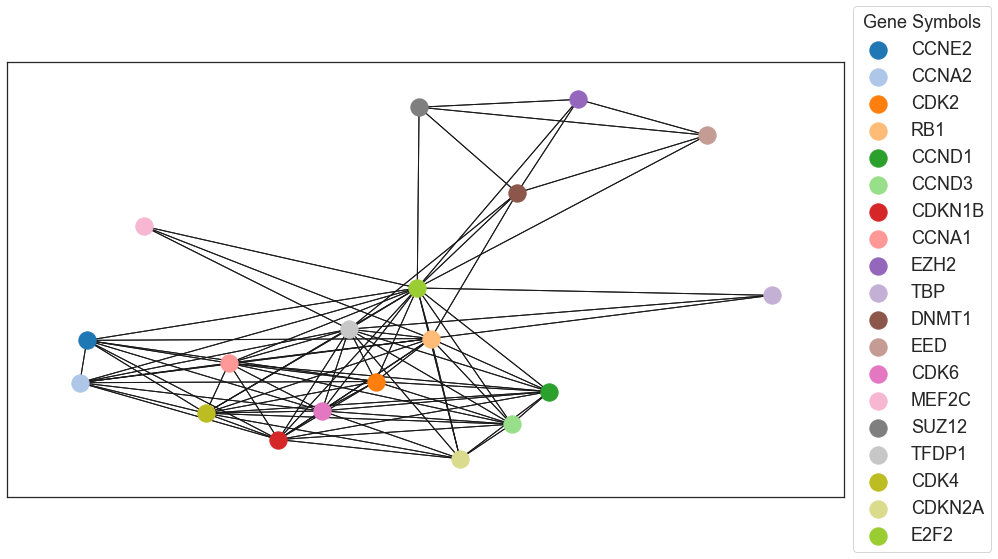

In [277]:
# this one is only for github

from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

frac = 2

thresh = 900

cl_graphs = diff_cl_graphs.get(thresh)
exG = diff_cl_graphs.get(thresh).get(exCl)

GENE_SYMBOL_IDXS = lst_GENE_SYMBOL_IDXS.get(thresh)
NEIGHBOR_GENE_TUPLES_UNDIRECTED = lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED.get(thresh)

gene_index = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_SYMBOL=='E2F2'].GENE_INDEX.values[0] # 12 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    # print(i)
    # print("  ", n)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{middle_node}')
nx.draw_networkx_edges(G, pos=pos, width=1, arrows=False); #, connectionstyle=f'arc3, rad = {0.25}')
legend = plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, title='Gene Symbols');
plt.setp(legend.get_title(),fontsize='18')
# plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
#           fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'imgs/GraphPlotForGene_{middle_node}_GITHUB.png', format='png', bbox_inches='tight');

Mean   number of neighbors: 11.198275566101074
Median number of neighbors: 5.0


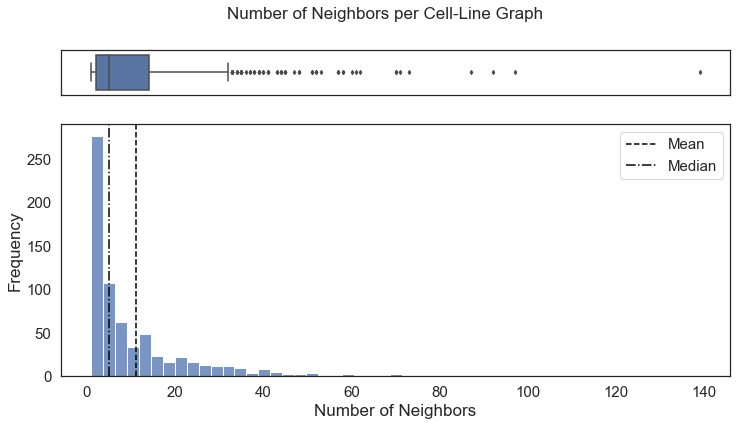

In [29]:
fac = 2

# Number of neighbors per graph.
node_degrees = degree(exG.edge_index[0], exG.num_nodes)
node_degrees_lst = [d.item() for d in node_degrees]
mu, med = torch.mean(node_degrees).item(), torch.median(node_degrees).item() 
print("Mean   number of neighbors:", mu)
print("Median number of neighbors:", med)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 6));

sns.histplot(x=node_degrees_lst, kde=False, ax=ax_hist, color='C0'); #, element="step"
sns.boxplot(x=node_degrees_lst, ax=ax_box, fliersize=3);
ax_hist.axvline(x=mu, color='black', linestyle='--', label='Mean', linewidth=1.5);
ax_hist.axvline(x=med, color='black', linestyle='-.', label='Median', linewidth=1.5);

plt.suptitle("Number of Neighbors per Cell-Line Graph", fontsize=PlottingParameters.TITLE_FONTSIZE.value+fac);
plt.xlabel("Number of Neighbors", fontsize=PlottingParameters.XLABEL_FONTSIZE.value+fac);
plt.ylabel("Frequency", fontsize=PlottingParameters.YLABEL_FONTSIZE.value+fac);
ax_hist.tick_params(axis='both', which='major', labelsize=PlottingParameters.XTICKS_LABELSIZE.value+fac);

ax_box.set(xlabel='');
plt.legend(fontsize=PlottingParameters.XTICKS_LABELSIZE.value+fac);
plt.show();
# f.savefig('imgs/NumberOfNeighborsPerCellLineGraphWithMeanMedian.eps', format='eps');

In [30]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

gene_index = 10 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos)
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5));
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/GraphPlotForGene_{middle_node}.svg', format='svg');

NameError: name 'NEIGHBOR_GENE_TUPLES_UNDIRECTED' is not defined

Mean   number of neighbors: 11.198275566101074
Median number of neighbors: 5.0


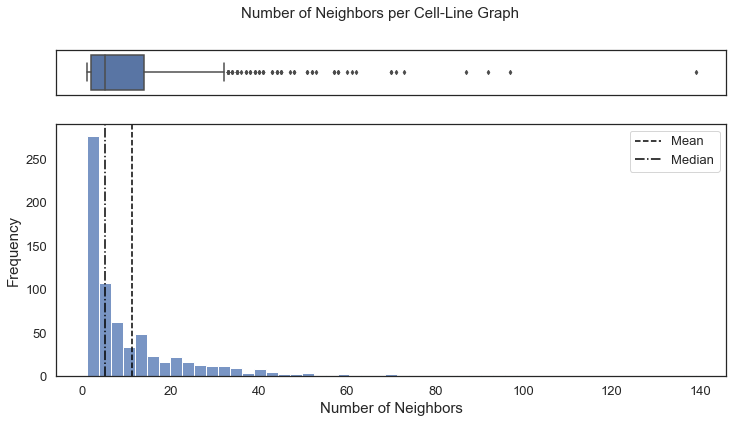

In [640]:
# Number of neighbors per graph.
node_degrees = degree(exG.edge_index[0], exG.num_nodes)
node_degrees_lst = [d.item() for d in node_degrees]
mu, med = torch.mean(node_degrees).item(), torch.median(node_degrees).item() 
print("Mean   number of neighbors:", mu)
print("Median number of neighbors:", med)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 6));

sns.histplot(x=node_degrees_lst, kde=False, ax=ax_hist, color='C0'); #, element="step"
sns.boxplot(x=node_degrees_lst, ax=ax_box, fliersize=3);
ax_hist.axvline(x=mu, color='black', linestyle='--', label='Mean', linewidth=1.5);
ax_hist.axvline(x=med, color='black', linestyle='-.', label='Median', linewidth=1.5);

plt.suptitle("Number of Neighbors per Cell-Line Graph", fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.xlabel("Number of Neighbors", fontsize=PlottingParameters.XLABEL_FONTSIZE.value);
plt.ylabel("Frequency", fontsize=PlottingParameters.YLABEL_FONTSIZE.value);
ax_hist.tick_params(axis='both', which='major', labelsize=PlottingParameters.XTICKS_LABELSIZE.value);

ax_box.set(xlabel='');
plt.legend(fontsize=PlottingParameters.XTICKS_LABELSIZE.value);
plt.show();
f.savefig(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/NumberOfNeighborsPerCellLineGraphWithMeanMedian.svg', format='svg');


        General graph information:
        topology           : Data(x=[38, 4], edge_index=[2, 208])
        num_nodes          : 38
        num_edges          : 208
        num_node_features  : 4
        num_edge_features  : 0
        has_isolated_nodes : True
        has_self_loops     : False
        is_directed        : False
        is_undirected      : True    
    


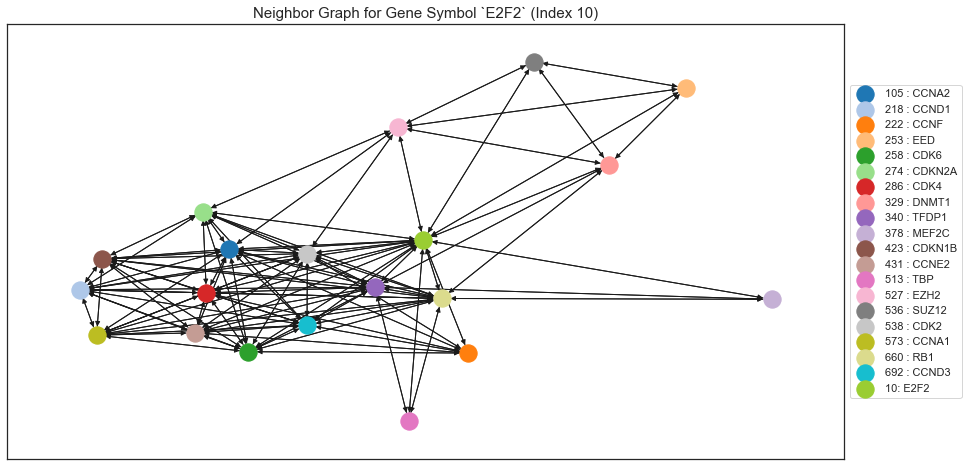

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [638]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.colors as cm

gene_index = 10 # 10
subset_neighbors = [tup for tup in NEIGHBOR_GENE_TUPLES_UNDIRECTED if tup[0]==gene_index]
subset = torch.tensor([item for sublist in subset_neighbors for item in sublist])
subG_edge_index, _ = subgraph(subset, exG.edge_index)
subG_x = torch.index_select(cl_graphs[exCl].x, 0, subset)
subG = Data(x=subG_x, edge_index=subG_edge_index)
print_graph_information(subG)

import networkx as nx
f, ax = plt.subplots(1, figsize=(15, 8));

G = to_networkx(subG)
d = torch.index_select(degree(exG.edge_index[0], exG.num_nodes), 0, torch.LongTensor(subset.unique().tolist()))

all_neighbors = subset.unique().tolist()
all_neighbors.remove(gene_index)
middle_node = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX==gene_index].GENE_SYMBOL.values[0]
neighbor_nodes = GENE_SYMBOL_IDXS.loc[GENE_SYMBOL_IDXS.GENE_INDEX.isin(all_neighbors)].GENE_SYMBOL.values.tolist()

yellowgreennode = [gene_index]

cmap = plt.get_cmap("tab20")
pos = nx.spring_layout(G)
for i, n in enumerate(all_neighbors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=300,
                           node_color=cm.to_hex(cmap(i)), label=f'{n} : {neighbor_nodes[i]}')
nx.draw_networkx_nodes(G, pos=pos, nodelist=yellowgreennode, node_size=300,
                       node_color='yellowgreen', label=f'{gene_index}: {middle_node}')
nx.draw_networkx_edges(G, pos=pos)
plt.legend(scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5));
plt.title(f'Neighbor Graph for Gene Symbol `{middle_node}` (Index {gene_index})', 
          fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.show()

SAVE = True
if SAVE:
    f.savefig(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/GraphPlotForGene_{middle_node}.svg', format='svg');